# 6-1构建模型的3种方法

可以使用以下3种方式构建模型：
* 使用Sequential按层顺序构建模型;
* 使用函数式API构建任意结构模型;
* 继承Model基类构建自定义模型。

对于顺序结构的模型，优先使用Sequential方法构建。

如果模型有多输入或者多输出，或者模型需要共享权重，或者模型具有残差连接等非顺序结构，推荐使用函数式API进行创建。

如果无特定必要，尽可能避免使用Model子类化的方式构建模型，这种方式提供了极大的灵活性，但也有更大的概率出错。

下面以IMDB电影评论的分类问题为例，演示3种创建模型的方法。

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tqdm import tqdm 
from tensorflow.keras import *


train_token_path = "../一、TensorFlow的建模流程/data/imdb/train_token.csv"
test_token_path = "../一、TensorFlow的建模流程/data/imdb/test_token.csv"

MAX_WORDS = 10000  # We will only consider the top 10,000 words in the dataset
MAX_LEN = 200  # We will cut reviews after 200 words
BATCH_SIZE = 20 

In [3]:
# 构建管道
def parse_line(line):
    t = tf.strings.split(line, "\t")
    label = tf.reshape(tf.cast(tf.strings.to_number(t[0]), tf.int32), (-1,))
    features = tf.cast(tf.strings.to_number(tf.strings.split(t[1], " ")), tf.int32)
    return (features, label)

ds_train = tf.data.TextLineDataset(filenames=[train_token_path]) \
        .map(parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
        .prefetch(tf.data.experimental.AUTOTUNE)

ds_test = tf.data.TextLineDataset(filenames=[test_token_path]) \
        .map(parse_line, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
        .shuffle(buffer_size=1000).batch(BATCH_SIZE) \
        .prefetch(tf.data.experimental.AUTOTUNE)

### 一、Sequential按层顺序创建模型

In [4]:
tf.keras.backend.clear_session()

model = models.Sequential()

model.add(layers.Embedding(MAX_WORDS, 7, input_length=MAX_LEN))
model.add(layers.Conv1D(filters=64, kernel_size=5, activation="relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Conv1D(filters=32, kernel_size=3, activation="relu"))
model.add(layers.MaxPool1D(2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="Nadam", 
             loss="binary_crossentropy",
             metrics=["accuracy", "AUC"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 7)            70000     
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 64)           2304      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 32)            6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 32)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

![](./data/Sequential模型结构.png)

In [7]:
import datetime
baselogger = callbacks.BaseLogger(stateful_metrics=["AUC"])
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train, validation_data=ds_test,
        epochs = 6, callbacks=[baselogger, tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.4572 - accuracy: 0.7586 - AUC: 0.8596 - val_loss: 0.3194 - val_accuracy: 0.8626 - val_AUC: 0.9386
Epoch 2/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.2486 - accuracy: 0.9010 - AUC: 0.9623 - val_loss: 0.3121 - val_accuracy: 0.8662 - val_AUC: 0.9431
Epoch 3/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1731 - accuracy: 0.9342 - AUC: 0.9816 - val_loss: 0.3785 - val_accuracy: 0.8588 - val_AUC: 0.9384
Epoch 4/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.1188 - accuracy: 0.9567 - AUC: 0.9910 - val_loss: 0.4403 - val_accuracy: 0.8604 - val_AUC: 0.9318
Epoch 5/6
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0717 - accuracy: 0.9753 - AUC: 0.9965 - val_loss: 0.5785 - val_accuracy: 0.8556 - val_AUC: 0.9211
Epoch 6/6
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0397 - accuracy: 0.9870 - AUC: 0.9988 - val_lo

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

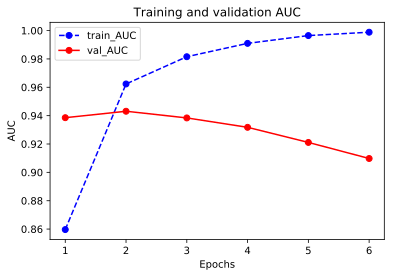

In [9]:
plot_metric(history,"AUC")

### 二、函数式API创建任意结构模型

In [11]:
tf.keras.backend.clear_session()

inputs = layers.Input(shape=[MAX_LEN])
x  = layers.Embedding(MAX_WORDS,7)(inputs)

branch1 = layers.SeparableConv1D(64, 3, activation="relu")(x)
branch1 = layers.MaxPool1D(3)(branch1)
branch1 = layers.SeparableConv1D(32, 3, activation="relu")(branch1)
branch1 = layers.GlobalMaxPool1D()(branch1)

branch2 = layers.SeparableConv1D(64, 5, activation="relu")(x)
branch2 = layers.MaxPool1D(5)(branch2)
branch2 = layers.SeparableConv1D(32, 5, activation="relu")(branch2)
branch2 = layers.GlobalMaxPooling1D()(branch2)

branch3 = layers.SeparableConv1D(64,7,activation="relu")(x)
branch3 = layers.MaxPool1D(7)(branch3)
branch3 = layers.SeparableConv1D(32,7,activation="relu")(branch3)
branch3 = layers.GlobalMaxPool1D()(branch3)

concat = layers.Concatenate()([branch1, branch2, branch3])
outputs = layers.Dense(1, activation="sigmoid")(concat)

model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="Nadam",
             loss="binary_crossentropy",
             metrics=["accuracy", "AUC"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 7)       70000       input_1[0][0]                    
__________________________________________________________________________________________________
separable_conv1d (SeparableConv (None, 198, 64)      533         embedding[0][0]                  
__________________________________________________________________________________________________
separable_conv1d_2 (SeparableCo (None, 196, 64)      547         embedding[0][0]                  
______________________________________________________________________________________________

![](./data/FunctionalAPI模型结构.png)

In [12]:
import datetime
logdir = "./data/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train, validation_data=ds_test, epochs=6, callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 14s 14ms/step - loss: 0.5413 - accuracy: 0.6811 - AUC: 0.7802 - val_loss: 0.3569 - val_accuracy: 0.8404 - val_AUC: 0.9230
Epoch 2/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2980 - accuracy: 0.8736 - AUC: 0.9458 - val_loss: 0.3250 - val_accuracy: 0.8622 - val_AUC: 0.9360
Epoch 3/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.2112 - accuracy: 0.9166 - AUC: 0.9727 - val_loss: 0.3516 - val_accuracy: 0.8616 - val_AUC: 0.9353
Epoch 4/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1474 - accuracy: 0.9464 - AUC: 0.9860 - val_loss: 0.4091 - val_accuracy: 0.8592 - val_AUC: 0.9316
Epoch 5/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0961 - accuracy: 0.9693 - AUC: 0.9934 - val_loss: 0.5021 - val_accuracy: 0.8484 - val_AUC: 0.9234
Epoch 6/6
1000/1000 [==============================] - 11s 11ms/step - loss: 0.0537 - accuracy: 0.9852 - AUC: 0.997

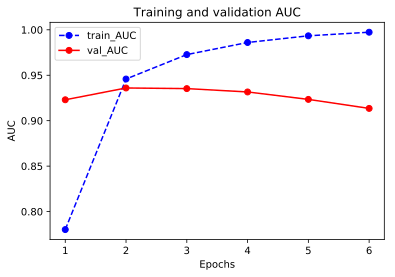

In [13]:
plot_metric(history,"AUC")

### 三、Model子类化创建自定义模型

In [19]:
# 先自定义一个残差模块，为自定义Layer
class ResBlock(layers.Layer):
    def __init__(self, kernel_size, **kwargs):
        super(ResBlock, self).__init__(**kwargs)
        self.kernel_size = kernel_size
        
    def build(self, input_shape):
        self.conv1 = layers.Conv1D(filters=64, kernel_size=self.kernel_size,
                                  activation="relu", padding="same")
        self.conv2 = layers.Conv1D(filters=32, kernel_size=self.kernel_size,
                                  activation="relu", padding="same")
        self.conv3 = layers.Conv1D(filters=input_shape[-1], 
                                  kernel_size=self.kernel_size, 
                                    activation="relu", padding="same")
        self.maxpool = layers.MaxPool1D(2)
        super(ResBlock, self).build(input_shape) # 相当于设置self.built = True
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = layers.Add()([inputs, x])
        x = self.maxpool(x)
        return x
    
    #如果要让自定义的Layer通过Functional API 组合成模型时可以序列化，需要自定义get_config方法。
    def get_config(self):
        config = super(ResBlock, self).get_config()
        config.update({"kernel_size": self.kernel_size})
        return config
        

In [20]:
# 测试ResBlock
resblock = ResBlock(kernel_size=3)
resblock.build(input_shape=(None, 200, 7))
resblock.compute_output_shape(input_shape=(None, 200, 7))

TensorShape([None, 100, 7])

In [21]:
# 自定义模型，实际上也可以使用Sequential或者FunctionalAPI

class ImdbModel(models.Model):
    def __init__(self):
        super(ImdbModel, self).__init__()
        
    def build(self,input_shape):
        self.embedding = layers.Embedding(MAX_WORDS,7)
        self.block1 = ResBlock(7)
        self.block2 = ResBlock(5)
        self.dense = layers.Dense(1,activation = "sigmoid")
        super(ImdbModel,self).build(input_shape)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.block1(x)
        x = self.block2(x)
        x = layers.Flatten()(x)
        x = self.dense(x)
        return(x)

In [22]:
tf.keras.backend.clear_session()

model = ImdbModel()
model.build(input_shape =(None,200))
model.summary()

model.compile(optimizer='Nadam',
            loss='binary_crossentropy',
            metrics=['accuracy',"AUC"])

Model: "imdb_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  70000     
_________________________________________________________________
res_block (ResBlock)         multiple                  19143     
_________________________________________________________________
res_block_1 (ResBlock)       multiple                  13703     
_________________________________________________________________
dense (Dense)                multiple                  351       
Total params: 103,197
Trainable params: 103,197
Non-trainable params: 0
_________________________________________________________________


![](./data/Model子类化模型结构.png)

In [23]:
import datetime

logdir = "./data/tflogs/keras_model/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
history = model.fit(ds_train, validation_data=ds_test,
                   epochs=6, callbacks=[tensorboard_callback])

Epoch 1/6
1000/1000 [==============================] - 27s 27ms/step - loss: 0.5312 - accuracy: 0.6869 - AUC: 0.7864 - val_loss: 0.3235 - val_accuracy: 0.8630 - val_AUC: 0.9386
Epoch 2/6
1000/1000 [==============================] - 24s 24ms/step - loss: 0.2548 - accuracy: 0.8974 - AUC: 0.9612 - val_loss: 0.3192 - val_accuracy: 0.8652 - val_AUC: 0.9463
Epoch 3/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.1636 - accuracy: 0.9372 - AUC: 0.9835 - val_loss: 0.3422 - val_accuracy: 0.8710 - val_AUC: 0.9429
Epoch 4/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0987 - accuracy: 0.9654 - AUC: 0.9935 - val_loss: 0.4823 - val_accuracy: 0.8560 - val_AUC: 0.9305
Epoch 5/6
1000/1000 [==============================] - 24s 24ms/step - loss: 0.0589 - accuracy: 0.9785 - AUC: 0.9974 - val_loss: 0.6083 - val_accuracy: 0.8540 - val_AUC: 0.9207
Epoch 6/6
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0335 - accuracy: 0.9883 - AUC: 0.999

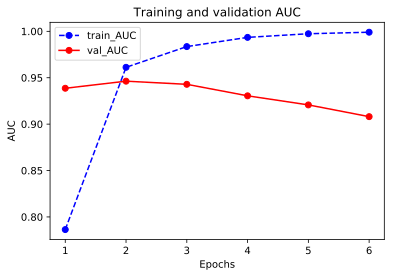

In [24]:
plot_metric(history,"AUC")